In [9]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import MLP
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import time
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn

In [10]:
# read data

dataPd = pd.read_csv('./../../data/glass/glass.data', sep=",", header=None)
glass = dataPd.to_numpy()

df = pd.DataFrame(glass, columns=['id', 'refractive index', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron', 'Class'])
df

,id,refractive index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Class
0,1.0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1.0
1,2.0,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1.0
2,3.0,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1.0
3,4.0,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1.0
4,5.0,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
209,210.0,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7.0
210,211.0,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7.0
211,212.0,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7.0
212,213.0,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7.0


In [11]:
# create a dataset class

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform):
        self.transform = transform
        self.data = data 
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index: int):
        data, label = self.data[index], self.labels[index]

        if self.transform is not None:
            data = self.transform(data)

        return data, label

In [12]:
# create datasets

columns = ['refractive index', 'Sodium', 'Magnesium', 'Aluminum', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron']
labelDescription = ['Building Float Window', 'Building Non-float Window', 'Vehicle Float Window', 'Vehicle Non-float Window', 'Container', 'Tableware', 'Headlamp']

xDf = df.iloc[:,1:-1]
for col in columns:
    xDf[col] = pd.to_numeric(xDf[col])

x = ((xDf-xDf.min())/(xDf.max()-xDf.min())).to_numpy()

y = pd.to_numeric(df.iloc[:,-1])
y = (y-1).to_numpy()

# split train data into train and validation sets without changing class distribution
# 80% train, 10% validation, 10% test
data_train, data_test, labels_train, labels_test = train_test_split(x, y, test_size=0.1, stratify=y)
data_train, data_valid, labels_train, labels_valid = train_test_split(data_train, labels_train, test_size=0.1111111111, stratify=labels_train)


batch_size=32

trainDataset = CustomDataset(data_train, labels_train, transform=None)
validDataset = CustomDataset(data_valid, labels_valid, transform=None)
testDataset = CustomDataset(data_test, labels_test, transform=None)



/tmp/ipykernel_145709/3062137150.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xDf[col] = pd.to_numeric(xDf[col])


In [13]:
# train

model = MLP(in_channels=9, hidden_channels=[100,100,100,100,100], activation_layer=nn.ReLU)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 1500
epoch_print_step = 100

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
train_f1_history = []
val_f1_history = []
timestart = time.time()

for epoch in range(epochs):
    # index 0 is for training, index 1 for validation
    epoch_loss = [0, 0]
    accuracy = [0, 0]
    f1_score = [0, 0]
    epochtime = time.time()
    
    for dataset, isTraining in [(trainDataset, True), (validDataset, False)]:
        correct = 0
        running_loss = 0.0
        all_input_labels = []
        all_predicted_labels = []

        if isTraining:
            model.train()
        else:
            model.eval()

        if isTraining:
            # zero the parameter gradients
            optimizer.zero_grad()

        data = torch.from_numpy(dataset.data).type(torch.FloatTensor)
        labels = torch.from_numpy(dataset.labels).type(torch.LongTensor)

        # forward 
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)

        if isTraining:
            # backward + optimize
            loss.backward()
            optimizer.step()

        # print statistics
        running_loss += loss.item() * data.size(0)
        correct += torch.sum(predicted == labels.data)
        all_predicted_labels.append(predicted)
        all_input_labels.append(labels)
        
        index = 0 if isTraining else 1
        epoch_loss[index] = running_loss / len(dataset)
        accuracy[index] = correct.double() / len(dataset)
        all_input_labels = np.concatenate(all_input_labels)
        all_predicted_labels = np.concatenate(all_predicted_labels)
        f1_score[index] = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

    if epoch % epoch_print_step == epoch_print_step-1:
        print("\r" + f'EPOCH: [{epoch + 1:2d}/{epochs}, {epoch_print_step}_time: {math.floor(time.time() - timestart)}s]   TRAIN: [loss: {epoch_loss[0]:.3f}, acc: {accuracy[0]:.3f}, f1: {f1_score[0]:.3f}]   VAL: [loss: {epoch_loss[1]:.3f}, acc: {accuracy[1]:.3f}, f1: {f1_score[1]:.3f}]') 
        timestart = time.time()
    train_loss_history.append(epoch_loss[0])
    val_loss_history.append(epoch_loss[1])
    train_acc_history.append(accuracy[0])
    val_acc_history.append(accuracy[1])
    train_f1_history.append(f1_score[0])
    val_f1_history.append(f1_score[1])

print('done')

EPOCH: [100/1500, 100_time: 1s]   TRAIN: [loss: 1.173, acc: 0.512, f1: 0.285]   VAL: [loss: 1.187, acc: 0.591, f1: 0.323]
EPOCH: [200/1500, 100_time: 1s]   TRAIN: [loss: 0.773, acc: 0.694, f1: 0.633]   VAL: [loss: 1.069, acc: 0.636, f1: 0.354]
EPOCH: [300/1500, 100_time: 1s]   TRAIN: [loss: 0.583, acc: 0.771, f1: 0.709]   VAL: [loss: 1.462, acc: 0.682, f1: 0.374]
EPOCH: [400/1500, 100_time: 1s]   TRAIN: [loss: 0.443, acc: 0.847, f1: 0.780]   VAL: [loss: 1.960, acc: 0.682, f1: 0.384]
EPOCH: [500/1500, 100_time: 1s]   TRAIN: [loss: 0.348, acc: 0.853, f1: 0.782]   VAL: [loss: 1.919, acc: 0.727, f1: 0.404]
EPOCH: [600/1500, 100_time: 0s]   TRAIN: [loss: 0.281, acc: 0.882, f1: 0.797]   VAL: [loss: 1.574, acc: 0.773, f1: 0.415]
EPOCH: [700/1500, 100_time: 1s]   TRAIN: [loss: 0.214, acc: 0.882, f1: 0.818]   VAL: [loss: 1.437, acc: 0.818, f1: 0.548]
EPOCH: [800/1500, 100_time: 0s]   TRAIN: [loss: 0.166, acc: 0.918, f1: 0.899]   VAL: [loss: 1.585, acc: 0.909, f1: 0.733]
EPOCH: [900/1500, 100_ti

[TEST] loss: 3.020, accuracy: 0.818, f1_score: 0.678
['Building Float Window', 'Building Non-float Window', 'Vehicle Float Window', 'Vehicle Non-float Window', 'Container', 'Tableware', 'Headlamp']
Axes(0.125,0.11;0.62x0.77)


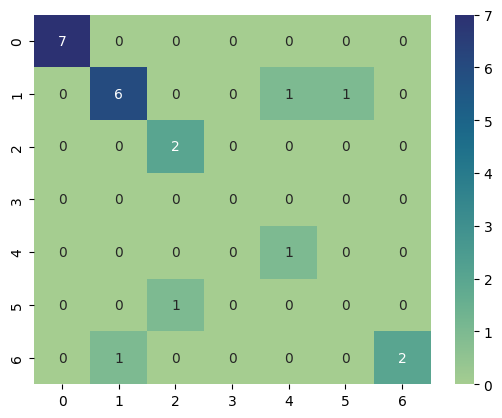

In [14]:
# test 

model.eval()

test_running_loss = 0
correct = 0
all_predicted_labels = []
all_input_labels = []

data = torch.from_numpy(dataset.data).type(torch.FloatTensor)
labels = torch.from_numpy(dataset.labels).type(torch.LongTensor)

outputs = model(data)
_, predicted = torch.max(outputs, 1)
loss = criterion(outputs, labels)

test_running_loss += loss.item() * data.size(0)
correct += torch.sum(predicted == labels.data)
all_predicted_labels.append(predicted)
all_input_labels.append(labels)

final_loss = test_running_loss / len(testDataset)
accuracy = correct.double() / len(testDataset)
all_input_labels = np.concatenate(all_input_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)
f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='macro')

print(f'[TEST] loss: {final_loss:.3f}, accuracy: {accuracy:.3f}, f1_score: {f1_score:.3f}')

# show confusion matrix
print(labelDescription)
print(sns.heatmap(confusion_matrix(all_input_labels, all_predicted_labels, labels=[i for i in range(7)]), annot=True, cmap="crest", fmt='g'))

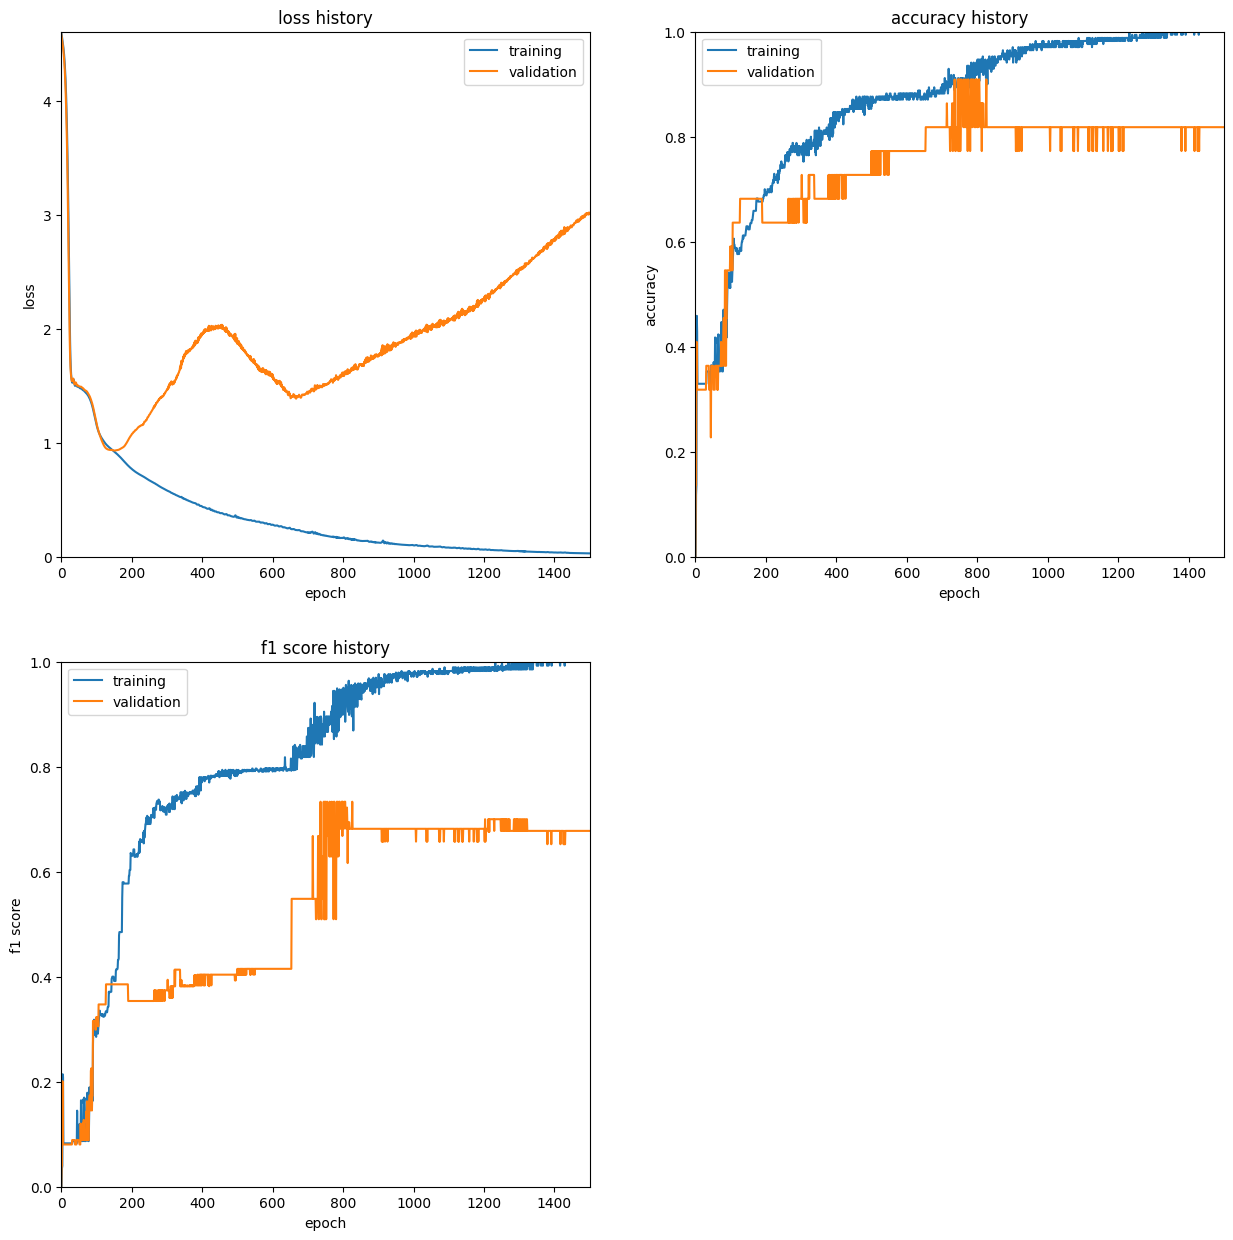

In [15]:
# plot train and validation loss

plt.figure(figsize = (15, 15))

plt.subplot(2, 2, 1)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0, len(train_loss_history))
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)))
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['training', 'validation'])

plt.subplot(2, 2, 2)
plt.title('accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(0, len(train_acc_history))
plt.ylim(0, 1)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['training', 'validation'])

plt.subplot(2, 2, 3)
plt.title('f1 score history')
plt.xlabel('epoch')
plt.ylabel('f1 score')
plt.xlim(0, len(train_f1_history))
plt.ylim(0, 1)
plt.plot(train_f1_history)
plt.plot(val_f1_history)
plt.legend(['training', 'validation'])

plt.show()